# Train

In [ ]:
# Cell 1 — imports & config
from pathlib import Path
import time, random, math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# your stuff
from src.utils.datasets import SimpleMelNpyDataset
from src.utils.utils import pick_device
from src.models import CNNVarTime

# --- reproducibility ---
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# --- paths / hparams ---
TRAIN_MANIFEST = "data/manifests/irmas_train_mels.csv"
CKPT_DIR = Path("saved_weights/irmas_pretrain"); CKPT_DIR.mkdir(parents=True, exist_ok=True)

# TODO: change these parameters 
EPOCHS       = 35
BATCH_SIZE   = 32
LR           = 3e-4
WEIGHT_DECAY = 1e-4
VAL_FRAC     = 0.15
DROPOUT      = 0.5
PATIENCE     = 8
NUM_WORKERS  = 0   

# --- device & AMP flags ---
DEVICE = pick_device()             # "cuda" | "mps" | "cpu"
pin_mem = (DEVICE == "cuda")
use_cuda_amp = (DEVICE == "cuda")
use_mps_amp  = (DEVICE == "mps")
scaler = torch.cuda.amp.GradScaler(enabled=use_cuda_amp)
print("Device:", DEVICE)


Device: mps


/var/folders/9g/kj2r9l693tgcs5y__cjlbp4r0000gn/T/ipykernel_21169/1192111825.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_cuda_amp)


In [ ]:
# Build label map from the manifest once (and keep it stable)
tmp_ds = SimpleMelNpyDataset(TRAIN_MANIFEST, per_example_norm=True)
label_to_idx = tmp_ds.label_to_idx
NUM_CLASSES = len(label_to_idx)
print("Classes:", label_to_idx)

# Full dataset with fixed mapping
full_ds = SimpleMelNpyDataset(
    TRAIN_MANIFEST,
    label_to_idx=label_to_idx,
    per_example_norm=True,
)

# Split train/val
N = len(full_ds); n_val = int(round(N * VAL_FRAC)); n_train = N - n_val
train_ds, val_ds = random_split(
    full_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)
# If you later add train-time aug inside the dataset, you can flip this flag:
val_ds.dataset.train = False

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=pin_mem, collate_fn=None
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=pin_mem, collate_fn=None
)

print("train size: ", len(train_ds), " val size: ", len(val_ds))

model = CNNVarTime(in_ch=2, num_classes=NUM_CLASSES, p_drop=DROPOUT).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()   # single-label

Classes: {'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4, 'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voi': 10}


(5699, 1006)

In [8]:
# Cell 4 — train loop (minimal, notebook friendly)

best_val_acc = 0.0
no_improve = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# # (Optional) Resume weights before the loop
# RESUME_CKPT = CKPT_DIR / "best_val_acc.pt"
# if RESUME_CKPT.exists():
#     ckpt = torch.load(RESUME_CKPT, map_type=torch.device(DEVICE))
#     model.load_state_dict(ckpt["model_state"], strict=True)
#     print("Warm-started from best_val_acc.pt")


for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # ----- Train -----
    model.train()
    tr_loss_sum = 0.0
    tr_correct = 0
    tr_total = 0
    nb = 0

    for X, y in train_loader:
        X = X.to(DEVICE, non_blocking=pin_mem)
        y = y.to(DEVICE, non_blocking=pin_mem)
        optimizer.zero_grad(set_to_none=True)

        if use_cuda_amp:
            with torch.cuda.amp.autocast():
                logits = model(X)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            if use_mps_amp:
                with torch.autocast(device_type="mps", dtype=torch.float16):
                    logits = model(X)
                    loss = criterion(logits, y)
            else:
                logits = model(X)
                loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

        tr_loss_sum += float(loss.item()) * y.size(0)
        tr_correct  += int((logits.argmax(1) == y).sum().item())
        tr_total    += int(y.size(0))
        nb += 1

    tr_loss = tr_loss_sum / max(1, tr_total)
    tr_acc  = tr_correct / max(1, tr_total)

    # ----- Val -----
    model.eval()
    va_loss_sum = 0.0
    va_correct = 0
    va_total = 0
    nb = 0

    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(DEVICE, non_blocking=pin_mem)
            y = y.to(DEVICE, non_blocking=pin_mem)

            if use_cuda_amp:
                with torch.cuda.amp.autocast():
                    logits = model(X)
                    loss = criterion(logits, y)
            else:
                if use_mps_amp:
                    with torch.autocast(device_type="mps", dtype=torch.float16):
                        logits = model(X)
                        loss = criterion(logits, y)
                else:
                    logits = model(X)
                    loss = criterion(logits, y)

            va_loss_sum += float(loss.item()) * y.size(0)
            va_correct  += int((logits.argmax(1) == y).sum().item())
            va_total    += int(y.size(0))
            nb += 1

    va_loss = va_loss_sum / max(1, va_total)
    va_acc  = va_correct / max(1, va_total)

    # step the epoch scheduler
    scheduler.step()

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    dt = time.time() - t0
    print(f"[{epoch:03d}/{EPOCHS}] "
          f"train {tr_loss:.4f}/{tr_acc:.4f} | "
          f"val {va_loss:.4f}/{va_acc:.4f} | "
          f"time {dt:.1f}s")

    # Save "last" every epoch
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "opt_state": optimizer.state_dict(),
        "sched_state": scheduler.state_dict(),
        "label_to_idx": label_to_idx,
        "history": history,
    }, CKPT_DIR / "last.pt")

    # Save "best" on validation accuracy
    if va_acc > best_val_acc + 1e-6:
        best_val_acc = va_acc
        no_improve = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": optimizer.state_dict(),
            "sched_state": scheduler.state_dict(),
            "label_to_idx": label_to_idx,
            "history": history,
        }, CKPT_DIR / "best_val_acc.pt")
        print(f"  ↑ new best val_acc: {best_val_acc:.4f}")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best val acc {best_val_acc:.4f}")
            break

print("Best val acc:", best_val_acc)


[001/30] train 2.3553/0.1456 | val 2.2101/0.2167 | time 20.7s
  ↑ new best val_acc: 0.2167
[002/30] train 2.2258/0.2025 | val 2.0557/0.2893 | time 12.8s
  ↑ new best val_acc: 0.2893
[003/30] train 2.1368/0.2446 | val 1.9579/0.3350 | time 12.8s
  ↑ new best val_acc: 0.3350
[004/30] train 2.0618/0.2693 | val 1.9701/0.3091 | time 14.0s
[005/30] train 2.0159/0.2957 | val 1.8288/0.3787 | time 13.2s
  ↑ new best val_acc: 0.3787
[006/30] train 1.9704/0.3064 | val 1.8008/0.3877 | time 12.3s
  ↑ new best val_acc: 0.3877
[007/30] train 1.9263/0.3243 | val 1.7593/0.4046 | time 13.6s
  ↑ new best val_acc: 0.4046
[008/30] train 1.8846/0.3385 | val 1.6835/0.4433 | time 14.1s
  ↑ new best val_acc: 0.4433
[009/30] train 1.8395/0.3662 | val 1.6706/0.4215 | time 13.1s
[010/30] train 1.8083/0.3752 | val 1.6075/0.4662 | time 13.2s
  ↑ new best val_acc: 0.4662
[011/30] train 1.7811/0.3873 | val 1.6505/0.4632 | time 12.1s
[012/30] train 1.7615/0.3959 | val 1.5274/0.4990 | time 11.2s
  ↑ new best val_acc: 0.

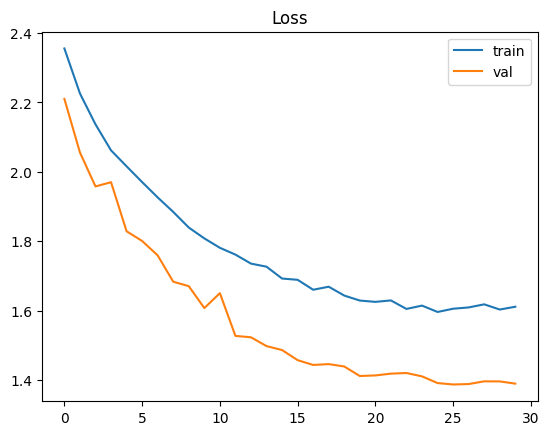

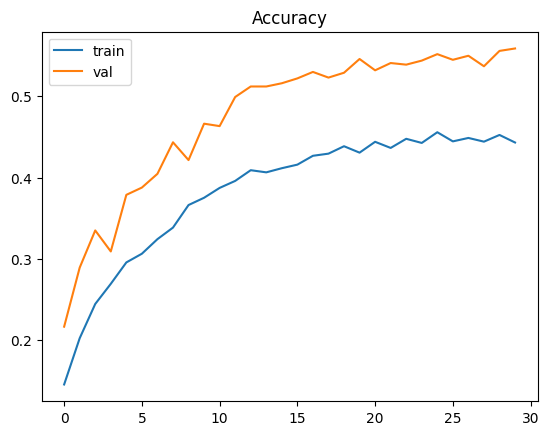

In [9]:
# Cell 5 — quick history plots (optional)
import matplotlib.pyplot as plt

plt.figure(); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.title("Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val"); plt.title("Accuracy"); plt.legend(); plt.show()
